# Importando e tratando os dados

In [170]:
!pip install numpy pandas seaborn matplotlib statsmodels statsforecast scikit-learn


In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [69]:
# Carregando os dados do arquivo CSV
df = pd.read_csv('dados_ibovespa.csv', sep=',', thousands='.', parse_dates=[0], date_format='%d.%m.%Y')
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2024-07-22,127860,127616,128151,127456,"6,10B","0,19%"
1,2024-07-19,127616,127652,128360,127413,"7,62B","-0,03%"
2,2024-07-18,127652,129450,129454,127523,"7,59B","-1,39%"
3,2024-07-17,129450,129112,129658,128741,"6,67B","0,26%"
4,2024-07-16,129110,129322,129521,128761,"6,82B","-0,16%"


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4953 entries, 0 to 4952
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      4953 non-null   datetime64[ns]
 1   Último    4953 non-null   int64         
 2   Abertura  4953 non-null   int64         
 3   Máxima    4953 non-null   int64         
 4   Mínima    4953 non-null   int64         
 5   Vol.      4952 non-null   object        
 6   Var%      4953 non-null   object        
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 271.0+ KB


In [71]:
# Lista de nomes das colunas desejados
nomes_colunas = ['data', 'fechamento','abertura', 'maxima', 'minima', 'volume', 'variacao']

# Renomeando as colunas
df.columns = nomes_colunas
df.head()

,data,fechamento,abertura,maxima,minima,volume,variacao
0,2024-07-22,127860,127616,128151,127456,"6,10B","0,19%"
1,2024-07-19,127616,127652,128360,127413,"7,62B","-0,03%"
2,2024-07-18,127652,129450,129454,127523,"7,59B","-1,39%"
3,2024-07-17,129450,129112,129658,128741,"6,67B","0,26%"
4,2024-07-16,129110,129322,129521,128761,"6,82B","-0,16%"


In [72]:
# Tratando volume - removendo letras e substituir vírgula por ponto
df['volume'] = df['volume'].str.replace('B', 'e9').str.replace('M', 'e6').str.replace('K','e3').str.replace(',', '.')

# Convertendo para numérico
df['volume'] = pd.to_numeric(df['volume'])

df.head()

,data,fechamento,abertura,maxima,minima,volume,variacao
0,2024-07-22,127860,127616,128151,127456,6.100000e+09,"0,19%"
1,2024-07-19,127616,127652,128360,127413,7.620000e+09,"-0,03%"
2,2024-07-18,127652,129450,129454,127523,7.590000e+09,"-1,39%"
3,2024-07-17,129450,129112,129658,128741,6.670000e+09,"0,26%"
4,2024-07-16,129110,129322,129521,128761,6.820000e+09,"-0,16%"


In [73]:
# Tratando variação - Removendo o símbolo de porcentagem e converter para float
df['variacao'] = df['variacao'].str.replace('%', '').str.replace(',', '.').astype(float)

df.head()

,data,fechamento,abertura,maxima,minima,volume,variacao
0,2024-07-22,127860,127616,128151,127456,6.100000e+09,0.19
1,2024-07-19,127616,127652,128360,127413,7.620000e+09,-0.03
2,2024-07-18,127652,129450,129454,127523,7.590000e+09,-1.39
3,2024-07-17,129450,129112,129658,128741,6.670000e+09,0.26
4,2024-07-16,129110,129322,129521,128761,6.820000e+09,-0.16


In [74]:
# Ordenando os dados pela data em ordem crescrente
df = df.sort_values('data').reset_index(drop=True)
df.head()

,data,fechamento,abertura,maxima,minima,volume,variacao
0,2004-07-22,21730,21821,21938,21490,247830000.0,-0.37
1,2004-07-23,21591,21729,22100,21559,318000000.0,-0.64
2,2004-07-26,21318,21635,21930,21056,227130000.0,-1.26
3,2004-07-27,21737,21325,21813,21236,282560000.0,1.97
4,2004-07-28,22168,21740,22213,21613,285650000.0,1.98


In [75]:
df.tail()

,data,fechamento,abertura,maxima,minima,volume,variacao
4948,2024-07-16,129110,129322,129521,128761,6.820000e+09,-0.16
4949,2024-07-17,129450,129112,129658,128741,6.670000e+09,0.26
4950,2024-07-18,127652,129450,129454,127523,7.590000e+09,-1.39
4951,2024-07-19,127616,127652,128360,127413,7.620000e+09,-0.03
4952,2024-07-22,127860,127616,128151,127456,6.100000e+09,0.19


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4953 entries, 0 to 4952
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   data        4953 non-null   datetime64[ns]
 1   fechamento  4953 non-null   int64         
 2   abertura    4953 non-null   int64         
 3   maxima      4953 non-null   int64         
 4   minima      4953 non-null   int64         
 5   volume      4952 non-null   float64       
 6   variacao    4953 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 271.0 KB


In [77]:
# convertendo data em índice
df = df.set_index('data')

df.head()

,fechamento,abertura,maxima,minima,volume,variacao
data,,,,,,
2004-07-22,21730,21821,21938,21490,247830000.0,-0.37
2004-07-23,21591,21729,22100,21559,318000000.0,-0.64
2004-07-26,21318,21635,21930,21056,227130000.0,-1.26
2004-07-27,21737,21325,21813,21236,282560000.0,1.97
2004-07-28,22168,21740,22213,21613,285650000.0,1.98


# Análise Exploratória dos Dados

## Passo 1: Visualização dos dados

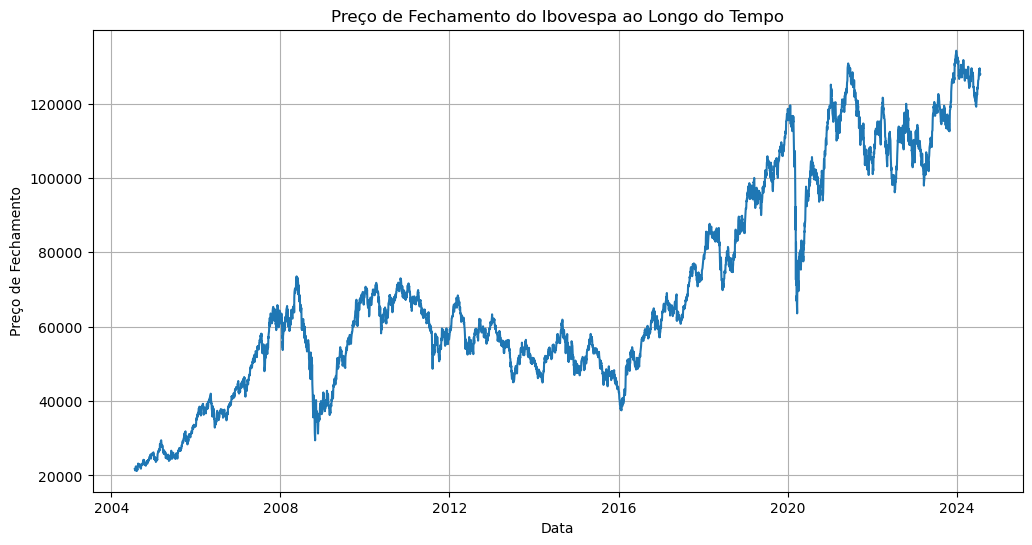

In [78]:
# Gráfico de linha do preço de fechamento ao longo do tempo

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['fechamento'], linestyle='-')
plt.title('Preço de Fechamento do Ibovespa ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.grid(True)
plt.show()

### Visualização das estatísticas rolantes

In [79]:
# Estatísticas rolantes
rolmean = df['fechamento'].rolling(window=12).mean()
rolstd = df['fechamento'].rolling(window=12).std()

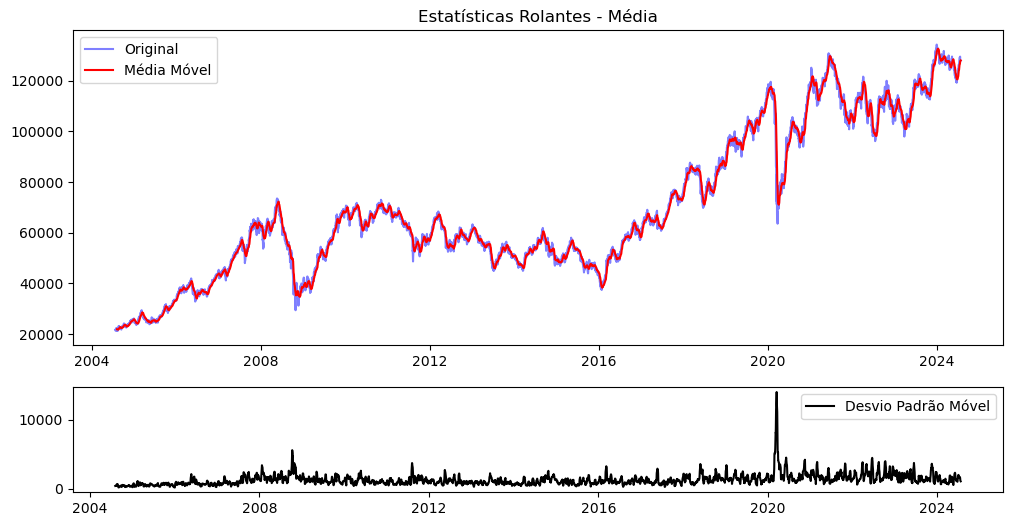

In [80]:
# Plot das estatísticas rolantes
fig = plt.figure(figsize=(12, 6))

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

ax1 = fig.add_subplot(gs[0])
ax1.plot(df['fechamento'], color='blue', label='Original', alpha=0.5)
ax1.plot(rolmean, color='red', label='Média Móvel')
ax1.legend(loc='best')
ax1.set_title('Estatísticas Rolantes - Média')

ax2 = fig.add_subplot(gs[1])
ax2.plot(rolstd, color='black', label='Desvio Padrão Móvel')
ax2.legend(loc='best')

plt.show()

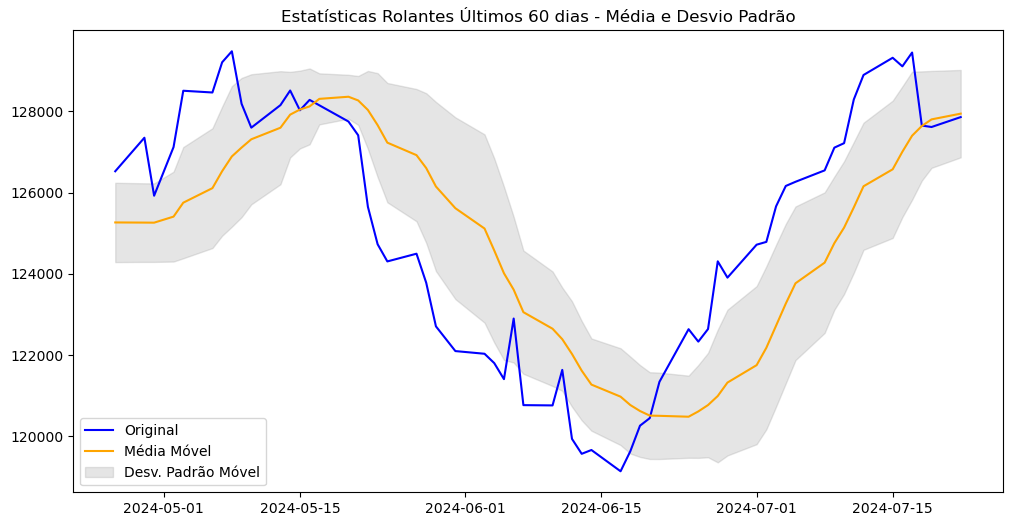

In [167]:
# Estatísticas Rolantes Últimos 60 dias

df_recent = df['fechamento'][-60:]
rolmean_recent = rolmean[-60:]
rolstd_recent = rolstd[-60:]

# Plot das estatísticas rolantes últimos 60 dias
plt.figure(figsize=(12, 6))
plt.plot(df_recent, color='blue', label='Original')
plt.plot(rolmean_recent, color='orange', label='Média Móvel')
plt.fill_between(df_recent.index, (rolmean_recent - rolstd_recent), (rolmean_recent + rolstd_recent), color='gray', alpha=0.2, label='Desv. Padrão Móvel')

plt.legend(loc='best')
plt.title('Estatísticas Rolantes Últimos 60 dias - Média e Desvio Padrão')
plt.show()

### Decomposição da Série Temporal

In [82]:
resultados = seasonal_decompose(df['fechamento'], model='additive', period=30)  # Exemplo de período sazonal de 30 dias

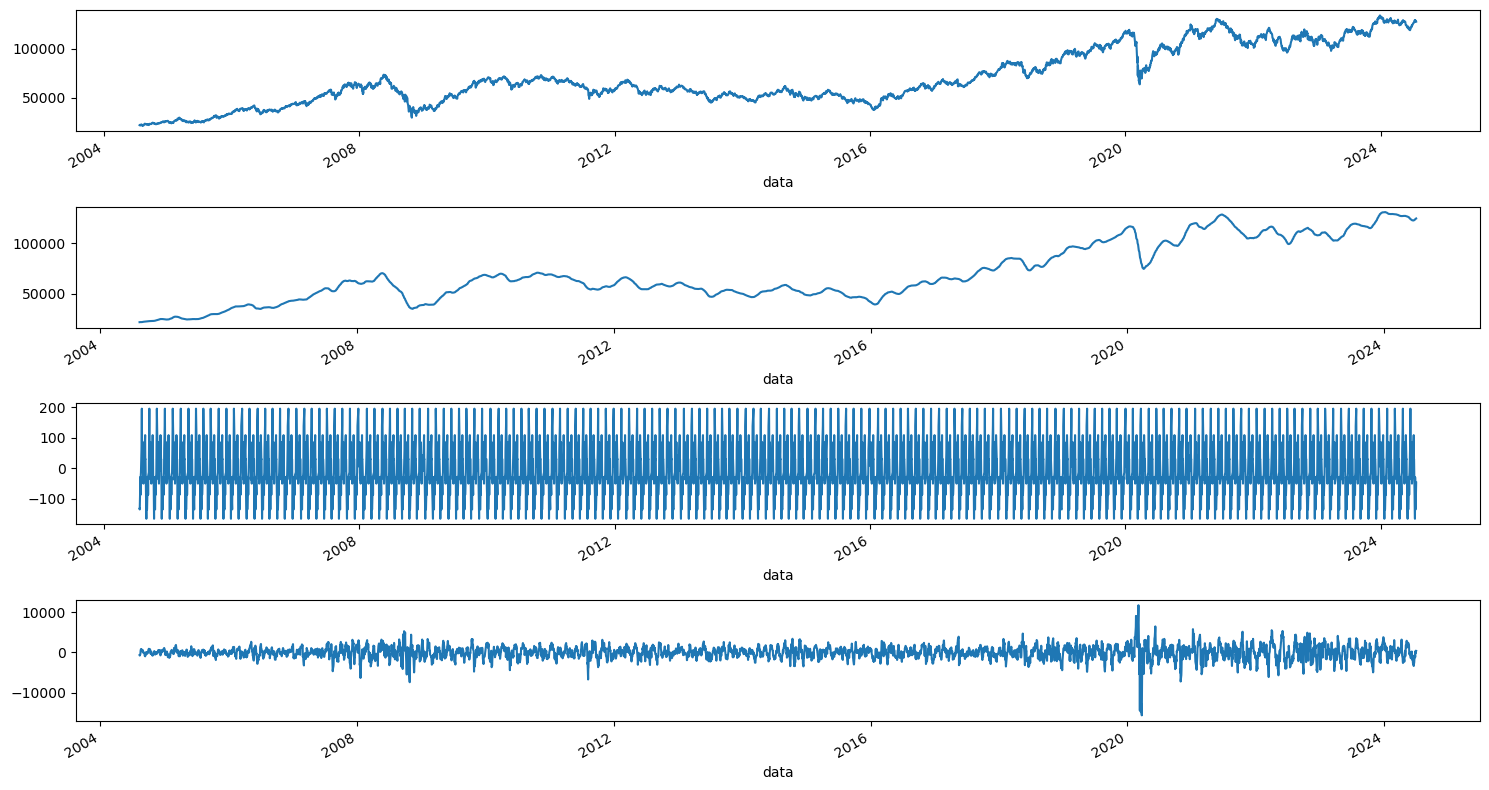

In [83]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))

resultados.observed.plot(ax = ax1)

#tendencia
resultados.trend.plot(ax = ax2)

#sazonalidade
resultados.seasonal.plot(ax = ax3)

#residuo dos dados
resultados.resid.plot(ax = ax4)

plt.tight_layout()

## Passo 2: Testes de estacionariedade e sazonalidade

### Teste de Estacionariedade

In [84]:
# Teste de Dickey-Fuller
print('Resultados do Teste de Dickey-Fuller:')
dftest = adfuller(df['fechamento'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Estatística do Teste', 'Valor-p', 'Número de Lags Usados', 'Número de Observações Usadas'])
for key, value in dftest[4].items():
    dfoutput['Valor Crítico (%s)' % key] = value
print(dfoutput)

# Verificar o valor-p e imprimir o resultado do teste de estacionariedade
if dftest[1] > 0.05:
    print("Provavelmente não é um grafico estacionariedade.")
else:
    print("Provavelmente é um grafico estacionariedade.")

Resultados do Teste de Dickey-Fuller:
Estatística do Teste              -1.222467
Valor-p                            0.663857
Número de Lags Usados             11.000000
Número de Observações Usadas    4941.000000
Valor Crítico (1%)                -3.431674
Valor Crítico (5%)                -2.862125
Valor Crítico (10%)               -2.567081
dtype: float64
Provavelmente não é um grafico estacionariedade.


### Teste de Sazonalidade

In [85]:
#TESTE DE SAZONALIDADE

# Separar os dados por períodos sazonais
groups = [group[1]['fechamento'].values for group in df.groupby(df.index.month)]

# Aplicar o teste de Fisher
statistic, p= stats.f_oneway(*groups)

# Imprimir o valor-p
print(f'Valor-p do teste de Fisher: {p:.4f}')

if p > 0.05:
  print("Não há evidencia suficiente para rejeitar a hipotese de sazonalidade")
else:
  print("A hipotese de sazonalidade é rejeitada")

Valor-p do teste de Fisher: 0.1588
Não há evidencia suficiente para rejeitar a hipotese de sazonalidade


### Análise dos Resultados

- Estatística do Teste (ADF): -1.222467

A estatística do teste de Dickey-Fuller é significativamente maior que os valores críticos em todos os níveis de significância (1%, 5%, 10%). Isso indica que não temos evidências estatísticas suficientes para rejeitar a hipótese nula de que a série possui uma raiz unitária, ou seja, podemos considerar a série como não estacionária, ou seja, apresenta tendências claras, sazonalidades ou variações que dependam do tempo.

- Valor-p: 0.68

O valor-p é não é pequeno (0.68), ou seja, 68% significativamente maior que qualquer nível de significância comum, algo em torno de 5% (0.05). Isso reforça ainda mais a conclusão de que a série não é estacionária.

#### Conclusão

Com base nos resultados do teste, podemos concluir que a série temporal do preço de fechamento do Ibovespa não é estacionária. A estatística do teste de ADF é maior que os valores críticos correspondentes e o valor-p alto, comparado com o nivel de signficancia comum (5%), indicando que há raiz unitária na série e que ela não é estacionária.

Portanto, podemos **proceder com confiança para modelagem e previsão usando métodos adequados para séries temporais como ARIMA** por exemplo.

# Predição

## Passo 1: Preparação dos Dados e Modelagem

In [86]:
df.shape

(4953, 6)

In [87]:
## Dividindo dados em treino e teste

tamanho_treino = df.shape[0] - 7
treino = df['fechamento'][:tamanho_treino]
teste = df['fechamento'][tamanho_treino:]

In [88]:
treino.tail()

data
2024-07-05    126267
2024-07-08    126548
2024-07-09    127108
2024-07-10    127218
2024-07-11    128294
Name: fechamento, dtype: int64

In [89]:
teste.head()

data
2024-07-12    128897
2024-07-15    129321
2024-07-16    129110
2024-07-17    129450
2024-07-18    127652
Name: fechamento, dtype: int64

In [90]:
df['fechamento'].shape

(4953,)

In [91]:
treino.shape

(4946,)

In [92]:
teste.shape

(7,)

## Passo 2: Métricas de avaliação dos modelos

In [189]:
# Funções de Avaliação
def calcula_metricas(modelo, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mape_prof = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    rmse = np.sqrt(mse)
    return pd.DataFrame([[modelo, mae, mse, mape, mape_prof, rmse]], columns=['Modelo', 'MAE', 'MSE', 'MAPE', 'MAPE Professor', 'RMSE'])

## Passo 2: Treinando e avaliando modelos

### ARIMA

In [94]:
# Ajustando o modelo ARIMA
modelo_arima = ARIMA(treino, order=(5, 1, 0))
modelo_arima_fit = modelo_arima.fit()

/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [95]:
# Fazendo previsões
previsoes_arima = modelo_arima_fit.predict(start=len(treino), end=len(treino) + len(teste) - 1, typ='levels')

/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [96]:
previsoes_arima.shape

(7,)

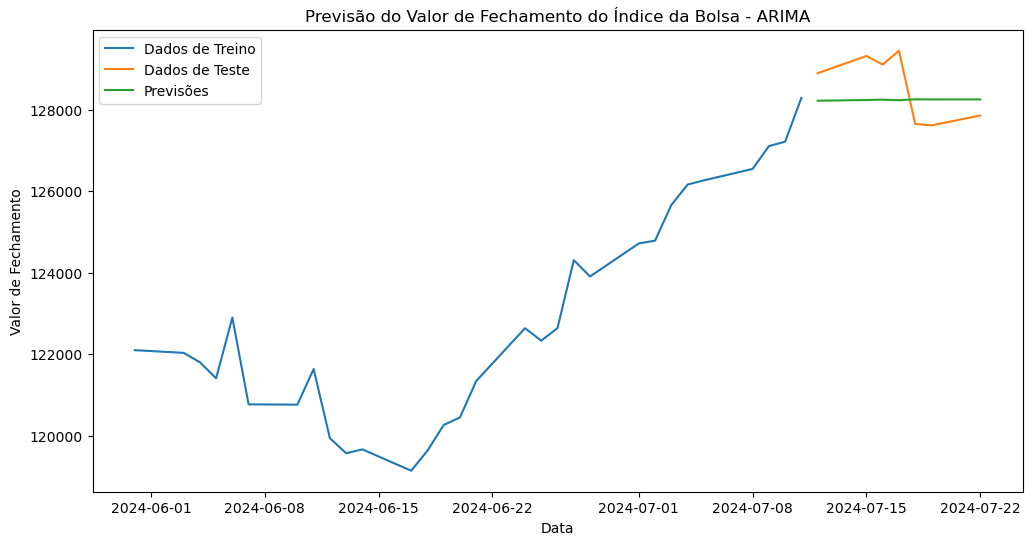

In [97]:
# Visualizando as previsões do modelo ARIMA
plt.figure(figsize=(12, 6))
plt.plot(treino[-30:], label='Dados de Treino')
plt.plot(teste.index, teste, label='Dados de Teste')
plt.plot(teste.index, previsoes_arima, label='Previsões')
plt.title('Previsão do Valor de Fechamento do Índice da Bolsa - ARIMA')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend()
plt.show()

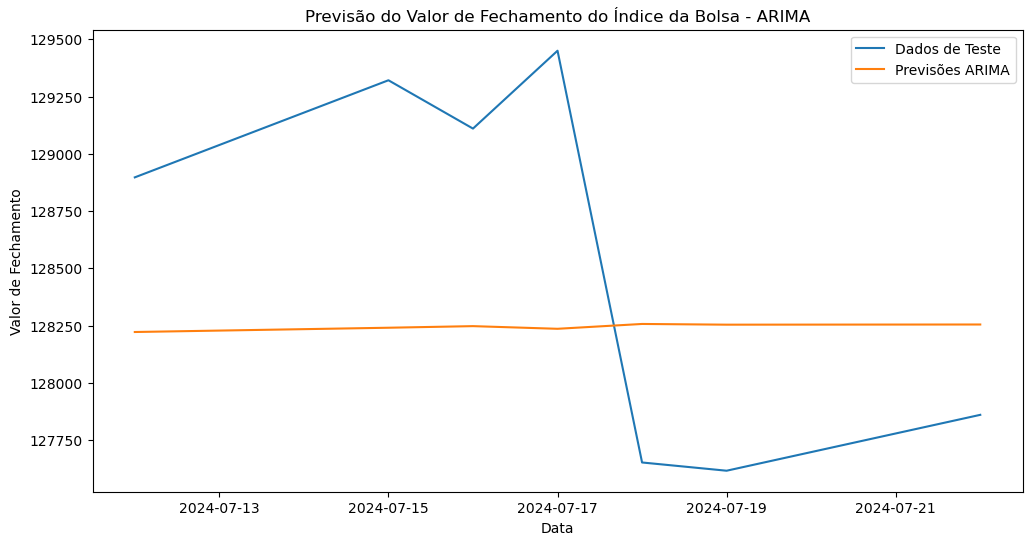

In [163]:
# Visualizando as previsões do modelo ARIMA
plt.figure(figsize=(12, 6))
plt.plot(teste.index, teste, label='Dados de Teste')
plt.plot(teste.index, previsoes_arima, label='Previsões ARIMA')
plt.title('Previsão do Valor de Fechamento do Índice da Bolsa - ARIMA')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend()
plt.show()

In [190]:
calcula_metricas('ARIMA', teste.values, previsoes_arima)

,Modelo,MAE,MSE,MAPE,MAPE Professor,RMSE
0,ARIMA,781.415531,681499.281358,0.006068,0.606825,825.529697


### AutoARIMA

In [100]:
treino

data
2004-07-22     21730
2004-07-23     21591
2004-07-26     21318
2004-07-27     21737
2004-07-28     22168
               ...  
2024-07-05    126267
2024-07-08    126548
2024-07-09    127108
2024-07-10    127218
2024-07-11    128294
Name: fechamento, Length: 4946, dtype: int64

In [168]:
treino_autoarima = pd.DataFrame(treino)
treino_autoarima = treino_autoarima.reset_index()
treino_autoarima = treino_autoarima.rename(columns={"data": "ds", "fechamento": "y"})
treino_autoarima['unique_id'] = 'Bolsa de Valores'
treino_autoarima.head()

,ds,y,unique_id
0,2004-07-22,21730,Bolsa de Valores
1,2004-07-23,21591,Bolsa de Valores
2,2004-07-26,21318,Bolsa de Valores
3,2004-07-27,21737,Bolsa de Valores
4,2004-07-28,22168,Bolsa de Valores


In [149]:
teste_autoarima = pd.DataFrame(teste)
teste_autoarima = teste_autoarima.reset_index()
teste_autoarima = teste_autoarima.rename(columns={"data": "ds", "fechamento": "y"})
teste_autoarima['unique_id'] = 'Bolsa de Valores'
teste_autoarima

,ds,y,unique_id
0,2024-07-12,128897,Bolsa de Valores
1,2024-07-15,129321,Bolsa de Valores
2,2024-07-16,129110,Bolsa de Valores
3,2024-07-17,129450,Bolsa de Valores
4,2024-07-18,127652,Bolsa de Valores
5,2024-07-19,127616,Bolsa de Valores
6,2024-07-22,127860,Bolsa de Valores


In [154]:
modelo_autoarima = StatsForecast(models=[AutoARIMA(season_length=1)], freq='B',n_jobs=-1) # season_length=1 (sem sazonalidade) freq='B' (dias úteis - business days)
modelo_autoarima.fit(treino_autoarima)
previsoes_autoarima= modelo_autoarima.predict(h=7, level = [90]) # h=7 (7 dias), level=[90] (nível de confiança)

/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [155]:
previsoes_autoarima

,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90
unique_id,,,,
Bolsa de Valores,2024-07-12,128218.750000,126390.109375,130047.398438
Bolsa de Valores,2024-07-15,128224.015625,125726.710938,130721.320312
Bolsa de Valores,2024-07-16,128223.648438,125197.156250,131250.140625
Bolsa de Valores,2024-07-17,128223.671875,124747.953125,131699.390625
Bolsa de Valores,2024-07-18,128223.671875,124350.468750,132096.875000
Bolsa de Valores,2024-07-19,128223.671875,123990.140625,132457.203125
Bolsa de Valores,2024-07-22,128223.671875,123658.156250,132789.187500


/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsforecast/core.py:1447: FutureWarning: Passing the ids as the index is deprecated. Please provide them as a column instead.
  warnings.warn(


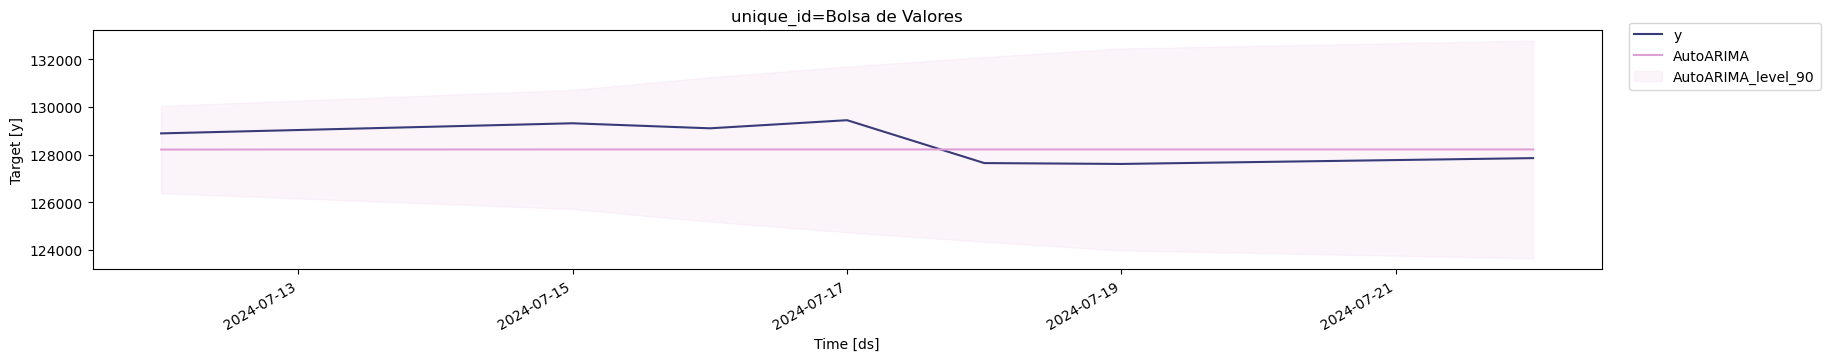

In [156]:
modelo_autoarima.plot(teste_autoarima, previsoes_autoarima, level = [90], unique_ids = ['Bolsa de Valores'], engine = 'matplotlib', max_insample_length=7)

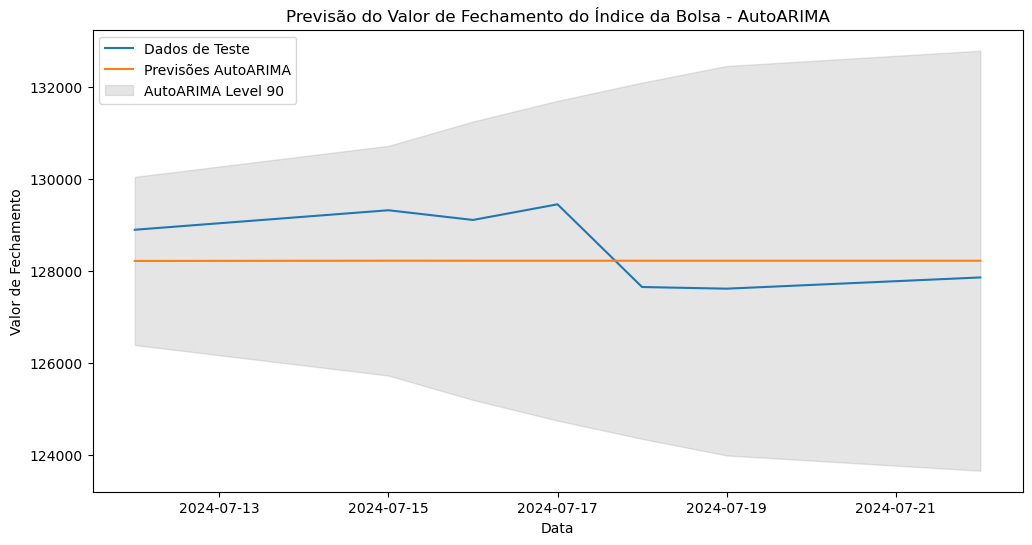

In [164]:
# Visualizando as previsões do modelo ARIMA
plt.figure(figsize=(12, 6))
plt.plot(teste_autoarima['ds'], teste_autoarima['y'], label='Dados de Teste')
plt.plot(previsoes_autoarima['ds'], previsoes_autoarima['AutoARIMA'], label='Previsões AutoARIMA')
plt.fill_between(previsoes_autoarima['ds'], previsoes_autoarima['AutoARIMA-lo-90'], previsoes_autoarima['AutoARIMA-hi-90'], color='gray', alpha=0.2, label='AutoARIMA Level 90')

plt.title('Previsão do Valor de Fechamento do Índice da Bolsa - AutoARIMA')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend(loc='upper left')
plt.show()

In [192]:
metricas = calcula_metricas(teste_autoarima.values, previsoes_autoarima)
imprime_metricas(metricas)

,Modelo,MAE,MSE,MAPE,MAPE Professor,RMSE
0,AutoARIMA,781.415531,681499.281358,0.006068,0.606825,825.529697
